In [1509]:
# Imports


from enum import Enum
import numpy as np
import matplotlib.pyplot as plt

In [1510]:
# 2-Stream radiative transfer


# Direction Enum
class Direction(Enum):
    UP = -1  # Define UP as going backwards
    DOWN = 1  # Define DOWN as going forwards


# Outcome Enum
class Outcome(Enum):
    REFLECTED = 1
    TRANSMITTED = 2
    ABSORBED = 3


# Photon class
class Photon:
    def __init__(self):
        self.depth = 0.0  # Position starting at top-of-atmosphere (TOA)
        self.direction = Direction.DOWN  # Initial direction
        self.weight = 1.0  # Initial weight, where weight ranges from 0 to 1
        self.alive = True  # Photon is initially alive


# Atmospheric layer class
class AtmosphericLayer:
    def __init__(self, optical_depth, ss_albedo, asymmetry):
        self.optical_depth = optical_depth  # Optical depth of the layer
        self.ss_albedo = ss_albedo  # Single-scattering albedo
        self.asymmetry_factor = asymmetry  # Asymmetry parameter

    def update_direction_asymmetry(self, photon_direction):
        # Boolean to determine if photon should change direction
        same_direction = (
            True if np.random.rand() < (1 + self.asymmetry_factor) / 2 else False
        )

        if photon_direction == Direction.UP:
            return Direction.UP if same_direction else Direction.DOWN
        else:
            return Direction.DOWN if same_direction else Direction.UP


# Atmosphere class
class Atmosphere:
    def __init__(self, layers):
        self.layers = layers  # List of AtmosphericLayer objects

    # Return total optical depth of the atmosphere
    def total_depth(self):
        return sum(layer.optical_depth for layer in self.layers)


# Helper function to sample optical depth from an exponential distribution
def sample_optical_depth():
    return -np.log(np.random.rand())  # Exponential distribution

In [1511]:
# Helper plotting function


# Plot the atmosphere in optical depth units
def plot_atmosphere(Atmosphere):
    layers = Atmosphere.layers

    fig, ax = plt.subplots(figsize=(6, 2))
    current_depth = 0.0
    for layer in layers:
        ax.fill_betweenx(
            [current_depth, current_depth + layer.optical_depth], 0, 1, alpha=0.3
        )
        current_depth += layer.optical_depth
    ax.set_ylim(current_depth, 0)
    ax.set_ylabel("Optical Depth")
    ax.xaxis.set_visible(False)
    plt.show()

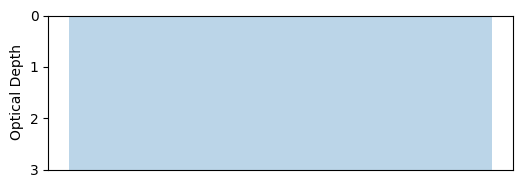

In [1512]:
# Create atmospheric layers

# Example: Simple single layer atmosphere
layer = AtmosphericLayer(optical_depth=3.0, ss_albedo=0.8, asymmetry=0.5)
atmosphere = Atmosphere([layer])

# Plot the atmosphere
plot_atmosphere(atmosphere)

In [1513]:
# Single photon simulation

THRESHOLD_WEIGHT = 0.01  # Weight threshold for terminating photon


def simulate_photon(atmosphere):
    photon = Photon()
    current_layer_index = 0  # Start at the top layer
    step_counter = 0
    photon_depths = [photon.depth]  # Store depths for plotting

    while photon.alive:
        step_counter += 1  # Update counter
        print(
            f"Step {step_counter} | Photon Direction: {photon.direction.name} | Weight: {photon.weight:.3f} | Layer Index: {current_layer_index}"
        )

        # Sample optical depth to next interaction
        tau = sample_optical_depth()
        print(f" Sampled optical depth step: {tau:.3f}")

        # Move photon to next interaction point
        photon.depth += tau * photon.direction.value
        print(f" Photon depth: {photon.depth:.3f}")
        photon_depths.append(photon.depth)  # Store depth for plotting

        # Check if photon exits the atmosphere
        if photon.depth < 0.0:
            print("Photon exited the atmosphere at TOA")
            photon.alive = False
            outcome = Outcome.REFLECTED
            break
        elif photon.depth > atmosphere.total_depth():
            print("Photon exited the atmosphere at BOA")
            photon.alive = False
            outcome = Outcome.TRANSMITTED
            break
        elif photon.weight < THRESHOLD_WEIGHT:
            print("Photon weight below threshold, terminating")
            photon.alive = False
            outcome = Outcome.ABSORBED
            break

        # If photon still inside atmosphere, handle interaction
        current_layer = atmosphere.layers[current_layer_index]
        photon.weight *= current_layer.ss_albedo  # Photon weight
        photon.direction = current_layer.update_direction_asymmetry(
            photon.direction
        )  # Update direction

    return outcome, photon_depths


outcome, photon_depths = simulate_photon(atmosphere)

Step 1 | Photon Direction: DOWN | Weight: 1.000 | Layer Index: 0
 Sampled optical depth step: 1.747
 Photon depth: 1.747
Step 2 | Photon Direction: DOWN | Weight: 0.800 | Layer Index: 0
 Sampled optical depth step: 1.268
 Photon depth: 3.015
Photon exited the atmosphere at BOA


In [1514]:
# Plot the photon path vs step number

# Helper plotting function


# Plot the atmosphere in optical depth units
def plot_atmosphere_with_photon_path(Atmosphere, photon_depths):
    layers = Atmosphere.layers
    total_steps = len(photon_depths)
    min_depth = min(photon_depths)
    max_depth = max(photon_depths)

    fig, ax = plt.subplots(figsize=(6, 2))
    current_depth = 0.0
    for layer in layers:
        ax.fill_betweenx(
            [current_depth, current_depth + layer.optical_depth],
            0,
            total_steps,
            alpha=0.3,
        )
    ax.set_ylim(max_depth, min_depth)
    ax.set_ylabel("Optical Depth")
    ax.set_xlabel("Step Number")

    # Plot the photon path via scatter-line plot
    for i, depth in enumerate(photon_depths):
        ax.scatter(i, depth, color="red")
        if i > 0:
            ax.plot([i - 1, i], [photon_depths[i - 1], depth], color="red")
    ax.legend(["Atmosphere", "Photon Path"])

    plt.show()

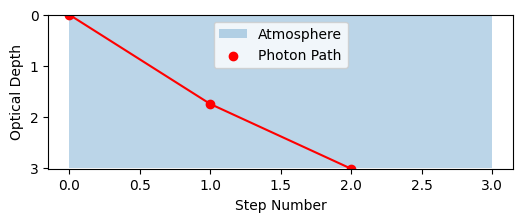

In [1515]:
# Plot photon path
plot_atmosphere_with_photon_path(atmosphere, photon_depths)

In [1516]:
# Monte Carlo simulation with energy tracking

THRESHOLD_WEIGHT = 0.01  # Weight threshold for terminating photon


def simulate_photon(atmosphere, verbose=False):
    """
    Simulate a single photon through the atmosphere.

    Args:
        atmosphere: Atmosphere object with layers
        verbose: If True, print detailed step-by-step information

    Returns:
        outcome: One of REFLECTED, TRANSMITTED, or ABSORBED
        final_weight: Final weight of photon when it exits/is absorbed
        photon_depths: List of depths for plotting (only if verbose=True)
    """
    photon = Photon()
    current_layer_index = 0
    step_counter = 0

    # Only track depths if verbose (for plotting single photon)
    photon_depths = [photon.depth] if verbose else None

    while photon.alive:
        step_counter += 1

        if verbose:
            print(
                f"Step {step_counter} | Direction: {photon.direction.name} | "
                f"Weight: {photon.weight:.3f} | Layer: {current_layer_index}"
            )

        # Sample optical depth to next interaction
        tau = sample_optical_depth()
        if verbose:
            print(f"  Sampled τ step: {tau:.3f}")

        # Move photon to next interaction point
        photon.depth += tau * photon.direction.value
        if verbose:
            print(f"  Photon depth: {photon.depth:.3f}")
            photon_depths.append(photon.depth)

        # Check if photon exits the atmosphere
        if photon.depth < 0.0:
            if verbose:
                print("  → Photon exited at TOA (reflected)")
            outcome = Outcome.REFLECTED
            break
        elif photon.depth > atmosphere.total_depth():
            if verbose:
                print("  → Photon exited at BOA (transmitted)")
            outcome = Outcome.TRANSMITTED
            break
        elif photon.weight < THRESHOLD_WEIGHT:
            if verbose:
                print("  → Photon weight below threshold (absorbed)")
            outcome = Outcome.ABSORBED
            break

        # Interaction: reduce weight (absorption) and scatter
        current_layer = atmosphere.layers[current_layer_index]
        photon.weight *= current_layer.ss_albedo
        photon.direction = current_layer.update_direction_asymmetry(photon.direction)

    return outcome, photon.weight, photon_depths


# Run single photon with detailed output
print("=" * 50)
print("SINGLE PHOTON SIMULATION (with detailed output)")
print("=" * 50)
outcome, final_weight, photon_depths = simulate_photon(atmosphere, verbose=True)
print(f"\nFinal outcome: {outcome.name}")
print(f"Final weight: {final_weight:.3f}\n")


# Run multiple photons and track ENERGY
print("=" * 50)
print("MULTIPLE PHOTON SIMULATION (energy tracking)")
print("=" * 50)

NUM_PHOTONS = 10000

# Track energy (sum of photon weights)
energy_reflected = 0.0
energy_transmitted = 0.0
energy_absorbed = 0.0

for i in range(NUM_PHOTONS):
    outcome, final_weight, _ = simulate_photon(atmosphere, verbose=False)

    if outcome == Outcome.REFLECTED:
        energy_reflected += final_weight
    elif outcome == Outcome.TRANSMITTED:
        energy_transmitted += final_weight
    elif outcome == Outcome.ABSORBED:
        energy_absorbed += 1.0 - final_weight  # Energy lost = initial - final

# Calculate percentages
total_energy = NUM_PHOTONS  # Each photon starts with weight 1.0
print(f"\nOut of {NUM_PHOTONS} photons (total energy = {total_energy}):")
print(
    f"  Reflected energy:    {energy_reflected:.1f} ({energy_reflected/total_energy*100:.1f}%)"
)
print(
    f"  Transmitted energy:  {energy_transmitted:.1f} ({energy_transmitted/total_energy*100:.1f}%)"
)
print(
    f"  Absorbed energy:     {energy_absorbed:.1f} ({energy_absorbed/total_energy*100:.1f}%)"
)
print(
    f"  Total:               {energy_reflected + energy_transmitted + energy_absorbed:.1f} "
    f"({(energy_reflected + energy_transmitted + energy_absorbed)/total_energy*100:.1f}%)"
)

SINGLE PHOTON SIMULATION (with detailed output)
Step 1 | Direction: DOWN | Weight: 1.000 | Layer: 0
  Sampled τ step: 1.972
  Photon depth: 1.972
Step 2 | Direction: UP | Weight: 0.800 | Layer: 0
  Sampled τ step: 0.164
  Photon depth: 1.808
Step 3 | Direction: DOWN | Weight: 0.640 | Layer: 0
  Sampled τ step: 1.459
  Photon depth: 3.266
  → Photon exited at BOA (transmitted)

Final outcome: TRANSMITTED
Final weight: 0.640

MULTIPLE PHOTON SIMULATION (energy tracking)

Out of 10000 photons (total energy = 10000):
  Reflected energy:    2429.1 (24.3%)
  Transmitted energy:  3301.0 (33.0%)
  Absorbed energy:     1.0 (0.0%)
  Total:               5731.2 (57.3%)


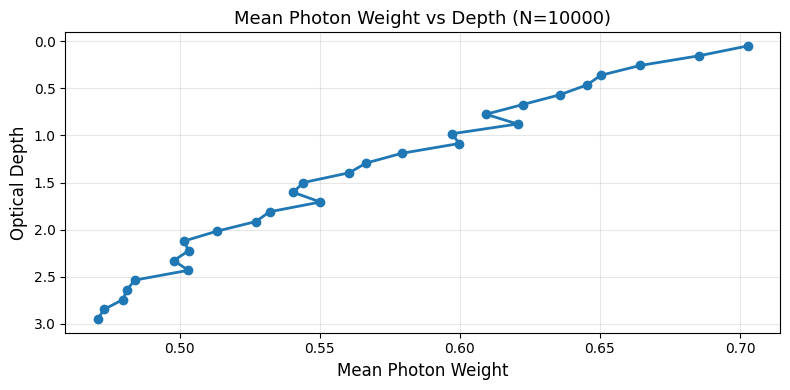

In [1517]:
# Monte Carlo simulation with weight vs depth tracking

from collections import defaultdict

THRESHOLD_WEIGHT = 0.01


def simulate_photon_with_tracking(atmosphere, depth_bins=None):
    """
    Simulate photon and track weight at different depths.

    Returns:
        outcome, final_weight, depth_weight_pairs
    """
    photon = Photon()
    current_layer_index = 0
    depth_weight_pairs = [(photon.depth, photon.weight)]

    while photon.alive:
        tau = sample_optical_depth()
        photon.depth += tau * photon.direction.value

        # Check boundaries
        if photon.depth < 0.0:
            outcome = Outcome.REFLECTED
            break
        elif photon.depth > atmosphere.total_depth():
            outcome = Outcome.TRANSMITTED
            break
        elif photon.weight < THRESHOLD_WEIGHT:
            outcome = Outcome.ABSORBED
            break

        # Interaction
        current_layer = atmosphere.layers[current_layer_index]
        photon.weight *= current_layer.ss_albedo
        photon.direction = current_layer.update_direction_asymmetry(photon.direction)

        # Store depth-weight pair
        depth_weight_pairs.append((photon.depth, photon.weight))

    return outcome, photon.weight, depth_weight_pairs


# Run MC simulation with depth tracking
NUM_PHOTONS = 10000
depth_bins = np.linspace(0, atmosphere.total_depth(), 30)
weights_by_depth = defaultdict(list)

for i in range(NUM_PHOTONS):
    outcome, final_weight, depth_weight_pairs = simulate_photon_with_tracking(
        atmosphere
    )

    # Bin the depth-weight data
    for depth, weight in depth_weight_pairs:
        if 0 <= depth <= atmosphere.total_depth():
            bin_idx = np.searchsorted(depth_bins, depth) - 1
            if 0 <= bin_idx < len(depth_bins) - 1:
                weights_by_depth[bin_idx].append(weight)

# Calculate mean weight at each depth bin
mean_weights = []
depth_centers = []
for i in range(len(depth_bins) - 1):
    if i in weights_by_depth and len(weights_by_depth[i]) > 0:
        mean_weights.append(np.mean(weights_by_depth[i]))
        depth_centers.append((depth_bins[i] + depth_bins[i + 1]) / 2)

# Plot mean photon weight vs depth
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(mean_weights, depth_centers, "o-", linewidth=2, markersize=6)
ax.set_xlabel("Mean Photon Weight", fontsize=12)
ax.set_ylabel("Optical Depth", fontsize=12)
ax.set_title(f"Mean Photon Weight vs Depth (N={NUM_PHOTONS})", fontsize=13)
ax.invert_yaxis()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Running optical depth sweep...
Running albedo sweep...
Running asymmetry sweep...
Sweeps complete! 🦎


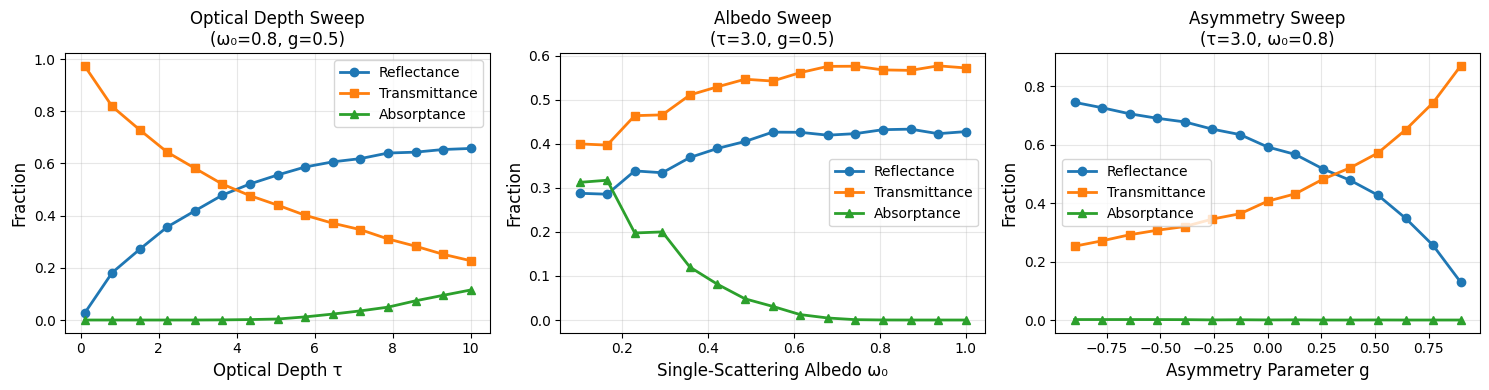

In [1518]:
# Parameter sweep: R, T, A vs optical depth, albedo, asymmetry


def run_monte_carlo(optical_depth, ss_albedo, asymmetry, n_photons=10000):
    """
    Run Monte Carlo simulation and return R, T, A fractions.
    """
    layer = AtmosphericLayer(
        optical_depth=optical_depth, ss_albedo=ss_albedo, asymmetry=asymmetry
    )
    atm = Atmosphere([layer])

    reflected = 0
    transmitted = 0
    absorbed = 0

    for _ in range(n_photons):
        outcome, _, _ = simulate_photon_with_tracking(atm)
        if outcome == Outcome.REFLECTED:
            reflected += 1
        elif outcome == Outcome.TRANSMITTED:
            transmitted += 1
        else:
            absorbed += 1

    return reflected / n_photons, transmitted / n_photons, absorbed / n_photons


# 1. OPTICAL DEPTH SWEEP
print("Running optical depth sweep...")
tau_values = np.linspace(0.1, 10, 15)
R_tau, T_tau, A_tau = [], [], []

for tau in tau_values:
    r, t, a = run_monte_carlo(optical_depth=tau, ss_albedo=0.8, asymmetry=0.5)
    R_tau.append(r)
    T_tau.append(t)
    A_tau.append(a)

# 2. SINGLE SCATTERING ALBEDO SWEEP
print("Running albedo sweep...")
albedo_values = np.linspace(0.1, 1.0, 15)
R_albedo, T_albedo, A_albedo = [], [], []

for albedo in albedo_values:
    r, t, a = run_monte_carlo(optical_depth=3.0, ss_albedo=albedo, asymmetry=0.5)
    R_albedo.append(r)
    T_albedo.append(t)
    A_albedo.append(a)

# 3. ASYMMETRY PARAMETER SWEEP
print("Running asymmetry sweep...")
g_values = np.linspace(-0.9, 0.9, 15)
R_g, T_g, A_g = [], [], []

for g in g_values:
    r, t, a = run_monte_carlo(optical_depth=3.0, ss_albedo=0.8, asymmetry=g)
    R_g.append(r)
    T_g.append(t)
    A_g.append(a)

print("Sweeps complete! 🦎")

# PLOT ALL THREE SWEEPS
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Optical Depth sweep
axes[0].plot(tau_values, R_tau, "o-", label="Reflectance", linewidth=2)
axes[0].plot(tau_values, T_tau, "s-", label="Transmittance", linewidth=2)
axes[0].plot(tau_values, A_tau, "^-", label="Absorptance", linewidth=2)
axes[0].set_xlabel("Optical Depth τ", fontsize=12)
axes[0].set_ylabel("Fraction", fontsize=12)
axes[0].set_title("Optical Depth Sweep\n(ω₀=0.8, g=0.5)", fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Albedo sweep
axes[1].plot(albedo_values, R_albedo, "o-", label="Reflectance", linewidth=2)
axes[1].plot(albedo_values, T_albedo, "s-", label="Transmittance", linewidth=2)
axes[1].plot(albedo_values, A_albedo, "^-", label="Absorptance", linewidth=2)
axes[1].set_xlabel("Single-Scattering Albedo ω₀", fontsize=12)
axes[1].set_ylabel("Fraction", fontsize=12)
axes[1].set_title("Albedo Sweep\n(τ=3.0, g=0.5)", fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Asymmetry sweep
axes[2].plot(g_values, R_g, "o-", label="Reflectance", linewidth=2)
axes[2].plot(g_values, T_g, "s-", label="Transmittance", linewidth=2)
axes[2].plot(g_values, A_g, "^-", label="Absorptance", linewidth=2)
axes[2].set_xlabel("Asymmetry Parameter g", fontsize=12)
axes[2].set_ylabel("Fraction", fontsize=12)
axes[2].set_title("Asymmetry Sweep\n(τ=3.0, ω₀=0.8)", fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Analytical 2-stream solution (Eddington approximation) - CORRECTED

def analytical_2stream(tau, omega0, g):
    """
    Compute reflectance and transmittance using analytical 2-stream solution.
    
    Based on Meador & Weaver (1980) formulation with Eddington closure.
    
    Args:
        tau: optical depth
        omega0: single-scattering albedo
        g: asymmetry parameter
    
    Returns:
        R, T (reflectance, transmittance)
    """
    # Special cases
    if tau == 0:
        return 0.0, 1.0
    
    # Eddington coefficients (Meador & Weaver 1980, Table 1)
    gamma1 = (7.0 - omega0 * (4.0 + 3.0 * g)) / 4.0
    gamma2 = -(1.0 - omega0 * (4.0 - 3.0 * g)) / 4.0
    gamma3 = (2.0 - 3.0 * g) / 4.0
    
    # For diffuse incident radiation (hemispheric)
    # We use gamma3 which accounts for the incident flux geometry
    
    # Compute k (eigenvalue) - controls exponential decay
    k = np.sqrt(gamma1**2 - gamma2**2)
    
    # Avoid numerical issues
    if k < 1e-10:
        k = 1e-10
    
    # Useful exponential terms
    exp_ktau = np.exp(k * tau)
    exp_minus_ktau = np.exp(-k * tau)
    
    # Denominator common to both R and T
    denom = (gamma1 + k) * exp_ktau - (gamma1 - k) * exp_minus_ktau
    
    if abs(denom) < 1e-10:
        return 0.0, 1.0
    
    # Reflectance for diffuse incident radiation
    # R = gamma2 * (exp(k*tau) - exp(-k*tau)) / denom
    R = gamma2 * (exp_ktau - exp_minus_ktau) / denom
    
    # Transmittance for diffuse incident radiation
    # T = 2*k / denom
    T = 2.0 * k / denom
    
    # Ensure physical bounds
    R = np.clip(R, 0.0, 1.0)
    T = np.clip(T, 0.0, 1.0)
    
    # Also ensure R + T <= 1 (conservation)
    if R + T > 1.0:
        total = R + T
        R = R / total
        T = T / total
    
    return R, T


# Compare MC vs Analytical for the three sweeps

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. OPTICAL DEPTH SWEEP COMPARISON
R_tau_analytical = []
T_tau_analytical = []
for tau in tau_values:
    r, t = analytical_2stream(tau, omega0=0.8, g=0.5)
    R_tau_analytical.append(r)
    T_tau_analytical.append(t)

axes[0].plot(tau_values, R_tau, 'o', label='MC Reflectance', markersize=8, alpha=0.7)
axes[0].plot(tau_values, T_tau, 's', label='MC Transmittance', markersize=8, alpha=0.7)
axes[0].plot(tau_values, R_tau_analytical, '-', label='Analytical R', linewidth=2)
axes[0].plot(tau_values, T_tau_analytical, '-', label='Analytical T', linewidth=2)
axes[0].set_xlabel('Optical Depth τ', fontsize=12)
axes[0].set_ylabel('Fraction', fontsize=12)
axes[0].set_title('Optical Depth: MC vs Analytical\n(ω₀=0.8, g=0.5)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. ALBEDO SWEEP COMPARISON
R_albedo_analytical = []
T_albedo_analytical = []
for omega0 in albedo_values:
    r, t = analytical_2stream(tau=3.0, omega0=omega0, g=0.5)
    R_albedo_analytical.append(r)
    T_albedo_analytical.append(t)

axes[1].plot(albedo_values, R_albedo, 'o', label='MC Reflectance', markersize=8, alpha=0.7)
axes[1].plot(albedo_values, T_albedo, 's', label='MC Transmittance', markersize=8, alpha=0.7)
axes[1].plot(albedo_values, R_albedo_analytical, '-', label='Analytical R', linewidth=2)
axes[1].plot(albedo_values, T_albedo_analytical, '-', label='Analytical T', linewidth=2)
axes[1].set_xlabel('Single-Scattering Albedo ω₀', fontsize=12)
axes[1].set_ylabel('Fraction', fontsize=12)
axes[1].set_title('Albedo: MC vs Analytical\n(τ=3.0, g=0.5)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. ASYMMETRY SWEEP COMPARISON
R_g_analytical = []
T_g_analytical = []
for g in g_values:
    r, t = analytical_2stream(tau=3.0, omega0=0.8, g=g)
    R_g_analytical.append(r)
    T_g_analytical.append(t)

axes[2].plot(g_values, R_g, 'o', label='MC Reflectance', markersize=8, alpha=0.7)
axes[2].plot(g_values, T_g, 's', label='MC Transmittance', markersize=8, alpha=0.7)
axes[2].plot(g_values, R_g_analytical, '-', label='Analytical R', linewidth=2)
axes[2].plot(g_values, T_g_analytical, '-', label='Analytical T', linewidth=2)
axes[2].set_xlabel('Asymmetry Parameter g', fontsize=12)
axes[2].set_ylabel('Fraction', fontsize=12)
axes[2].set_title('Asymmetry: MC vs Analytical\n(τ=3.0, ω₀=0.8)', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some quantitative comparison
print("\nQuantitative Comparison (sample points):")
print("=" * 60)
print(f"Optical Depth τ=3.0 (ω₀=0.8, g=0.5):")
r_mc, t_mc, a_mc = run_monte_carlo(3.0, 0.8, 0.5, n_photons=5000)
r_an, t_an = analytical_2stream(3.0, 0.8, 0.5)
print(f"  MC:         R={r_mc:.4f}, T={t_mc:.4f}, A={a_mc:.4f}")
print(f"  Analytical: R={r_an:.4f}, T={t_an:.4f}, A={1-r_an-t_an:.4f}")
print(f"  Error:      R={abs(r_mc-r_an):.4f}, T={abs(t_mc-t_an):.4f}")
print()